In [1]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import pickle

from models.value_models import ValueLinearModel, ValueNormedModel
from models.multinomial_logistic_regressor import MultinomialLogisticRegressor, NormedMultinomialLogisticRegressor
from models.model_wrapper import ModelWrapper

from models.trainer import Trainer

import torch

import plotly.express as px

matplotlib.rcParams['figure.dpi'] = 300
from itertools import accumulate

species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500


In [2]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)

In [4]:
valid_beh.columns

Index(['TrialNumber', 'BlockNumber', 'TrialAfterRuleChange', 'TaskInterrupt',
       'ConditionNumber', 'Response', 'ItemChosen', 'TrialType', 'CurrentRule',
       'LastRule', 'ShiftType', 'Perseveration', 'TrialStart', 'FixCrossOn',
       'FixationOnCross', 'FixRequireEnd', 'StimOnset', 'FeedbackEncode',
       'FeedbackOnset', 'TrialEnd', 'Item0_xPos', 'Item0_yPos', 'Item1_xPos',
       'Item1_yPos', 'Item2_xPos', 'Item2_yPos', 'Item3_xPos', 'Item3_yPos',
       'Item0Shape', 'Item0Color', 'Item0Pattern', 'Item1Shape', 'Item1Color',
       'Item1Pattern', 'Item2Shape', 'Item2Color', 'Item2Pattern',
       'Item3Shape', 'Item3Color', 'Item3Pattern'],
      dtype='object')

In [3]:
lfp = pd.read_csv(fs.open("l2l.jbferre.scratch/for_Patrick/fix.csv"))

/tmp/ipykernel_1976815/4004171884.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  lfp = pd.read_csv(fs.open("l2l.jbferre.scratch/for_Patrick/fix.csv"))


In [30]:
electrode_pos = lfp_development.get_electrode_xyz(fs, "nhp", subject, "WCST", str(session), chans_spc="all")
# electrode_pos = electrode_pos[electrode_pos['ch'].isin(lfp.ChanID.unique().astype('str'))]

In [31]:
brain_areas = lfp_development.get_brain_areas(fs, 'nhp', subject, "WCST", str(session))

In [32]:
np_pos = electrode_pos[['x', 'y', 'z']].to_numpy()
spatial_clusters = KMeans(n_clusters=5, random_state=0).fit_predict(np_pos)
electrode_pos["spatial_cluster"] = spatial_clusters 


In [33]:
name_to_color = {
    "anterior hippocampus": '#3366CC', 
    "mpfc" : '#DC3912', 
    "parietal": '#FF9900', 
    "posterior hippocampus": '#109618', 
    "lpfc/fef": '#990099'
}

spatial_cluster_mapping = np.array(["anterior hippocampus", "mpfc", "parietal", "posterior hippocampus", "lpfc/fef"])
electrode_pos["SpatialClusterName"] = spatial_cluster_mapping[electrode_pos["spatial_cluster"]]

In [34]:
np.unique(spatial_clusters, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([61, 58, 26, 38, 37]))

In [35]:
electrode_pos_filt = electrode_pos[electrode_pos['ch'].isin(lfp.ChanID.unique().astype('str'))]

In [22]:
# Visualize spatial clusters for LFP
fig1 = px.scatter_3d(
    electrode_pos_filt, x="x", y="y", z="z", 
    color="SpatialClusterName",
    labels={"SpatialClusterName": "Electrode Location"},
    color_discrete_map=name_to_color
)
fig = visualization_utils.plotly_add_glass_brain(fs, fig1, subject, areas='all', show_axis=False)
fig.update_layout(
    autosize=True,
    width=750,
    height=700,
)
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.55,
        xanchor="left",
        x=1,
        font=dict(
            size = 20
        )
    ),
    legend_title = dict(
        font = dict(size = 20))
)
fig.write_html("../data/lfp_spatial_clusters.html")

In [23]:
freq = "bp_4-5"
models = np.load(
    fs.open(f"l2l.pqz317.scratch/value_model_lfp_{freq}_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"),
    allow_pickle=True
)
weights = classifier_utils.evaluate_model_weights_by_time_bins(models, 202, 12)
weights_df = classifier_utils.convert_model_weights_to_df(weights, -1300, 100)


202


In [24]:
spatial_clusters_filt = electrode_pos_filt.spatial_cluster.values

In [25]:
spatial_cluster_mapping = np.array(["anterior hippocampus", "mpfc", "parietal", "posterior hippocampus", "lpfc/fef"])

mpfc = np.argwhere(spatial_clusters_filt == 1)
lpfc = np.argwhere(spatial_clusters_filt == 4)
ant_hipp = np.argwhere(spatial_clusters_filt == 0)
post_hipp = np.argwhere(spatial_clusters_filt == 3)
parietal = np.argwhere(spatial_clusters_filt == 2)

reordered_units = np.squeeze(np.concatenate((mpfc, lpfc, parietal, post_hipp, ant_hipp)))

In [26]:
regs = [mpfc, lpfc, parietal, post_hipp, ant_hipp]
lens = [len(reg) for reg in regs]
lens_accum = list(accumulate(lens))
reg_start = lens_accum[:-1].insert(0, 0)
reg_end = list(np.array(lens_accum[1:]) - 1)
lines = np.array(lens_accum[0:-1]) - 0.5

[ 50.5  87.5 110.5 142.5]
6


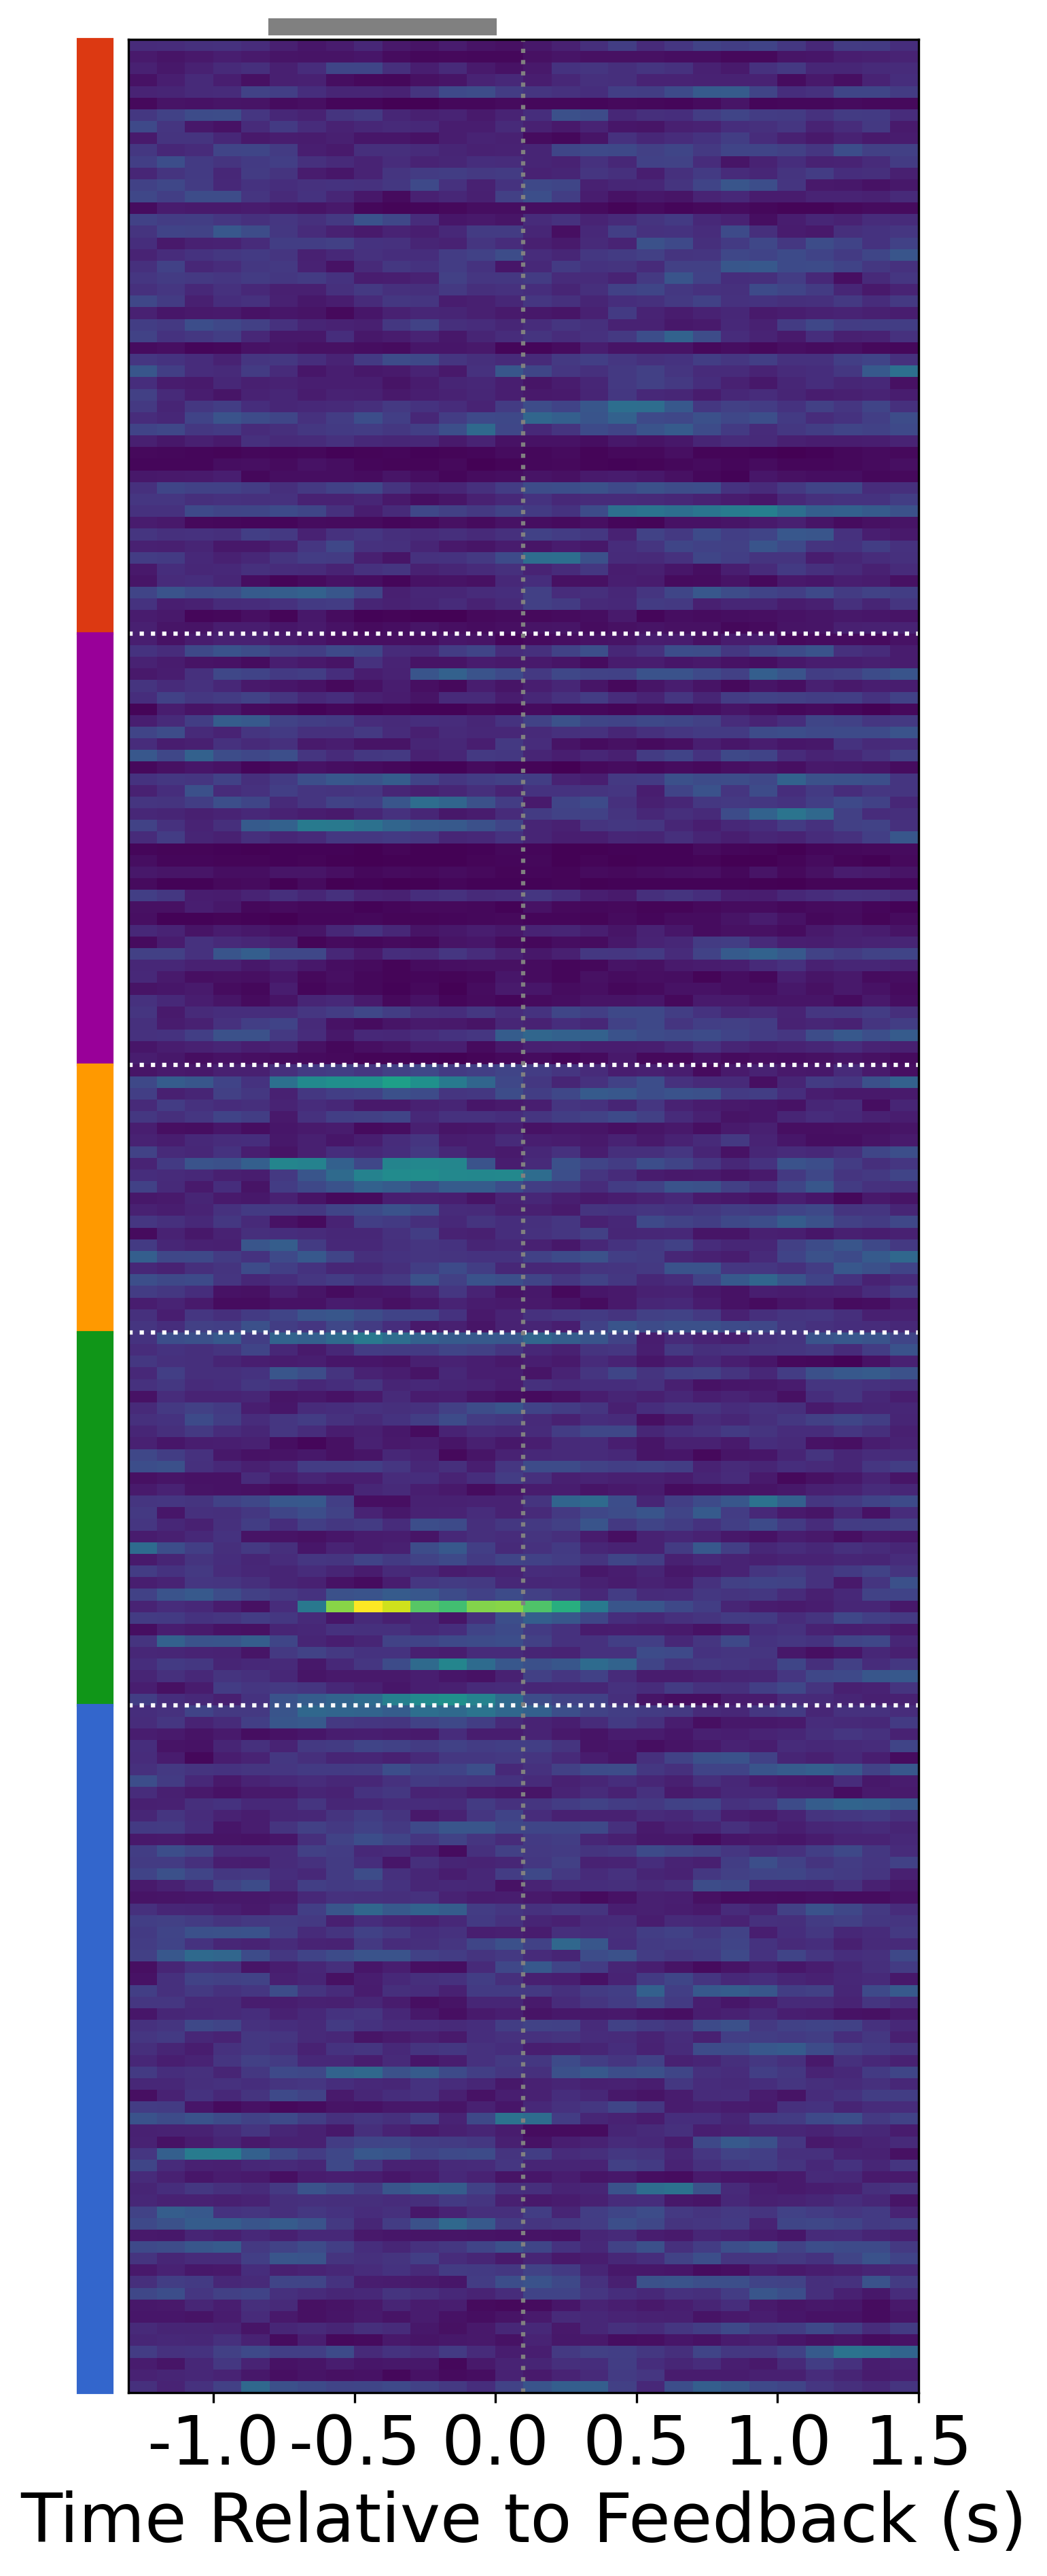

In [47]:

name_to_color = {
    "anterior hippocampus": '#3366CC', 
    "mpfc" : '#DC3912', 
    "parietal": '#FF9900', 
    "posterior hippocampus": '#109618', 
    "lpfc/fef": '#990099'
}
colormap = ["#DC3912", "#990099", "#FF9900", "#109618", "#3366CC"]
# models are num_time_points x num_models
pre_interval = 1300
post_interval = 1500
freq = "bp_4-5"
models = np.load(
    fs.open(f"l2l.pqz317.scratch/value_model_lfp_{freq}_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"),
    allow_pickle=True
)
weights = classifier_utils.evaluate_model_weights_by_time_bins(models, 202, 12)

sums = np.sum(weights, axis=0)

normalized = weights / sums

# reorder by temp then ant
reordered = normalized[reordered_units, :]


matplotlib.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(figsize=(5, 15))
colors = ax.matshow(reordered, aspect='auto')
# tick_labels = np.array([-1.2, -0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9, 1.2])
tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
tick_pos = (tick_labels + 1.3) * 10 - 0.5
# fig.colorbar(colors)
# axis = np.arange(0, 28, 3)
# labels = np.around((axis - 13) * 0.1, 1)
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)
ax.xaxis.tick_bottom()
ax.set_xlabel("Time Relative to Feedback (s)")
ax.get_yaxis().set_visible(False)
ax.set_ylabel([])
# y_axis = np.arange(0, 59, 5)
# ax.set_yticks(y_axis)
# ax.set_yticklabels(y_axis)

boundaries = np.insert(np.insert(lines, len(lines), reordered.shape[0] - 0.5), 0, -0.5)
print(lines)
print(len(boundaries))
for line in lines:
    ax.axhline(line, color='white', linestyle="dotted")

for i in range(len(boundaries)-1):
    rect = patches.Rectangle(
        (
            -1.3 - 1,
            (boundaries[i])#+boundaries[i+1]) / 2
        ),
        1.2,
        (boundaries[i+1]-boundaries[i]),
        edgecolor=colormap[i],
        facecolor=colormap[i],
        clip_on=False
    )
    ax.add_patch(rect)
gray_rect = patches.Rectangle(
    (4.5, -2.2), 8, 1.2,
    edgecolor="gray",
    facecolor="gray",
    clip_on=False,
)
ax.add_patch(gray_rect)
ax.axvline(13.48, color="gray", linestyle="dotted")



In [27]:
units = spike_general.list_session_units(fs, subject, session)

unit_pos = pd.merge(units, electrode_pos, left_on="Channel", right_on="ch", how="left")
unit_pos = unit_pos.astype({"UnitID": int})

In [29]:
fig1 = px.scatter_3d(
    unit_pos, x="x", y="y", z="z", 
    color="SpatialClusterName", 
    labels={"SpatialClusterName": "Unit Location"},
    color_discrete_map=name_to_color)
fig = visualization_utils.plotly_add_glass_brain(fs, fig1, subject, areas='all', show_axis=False)
fig.update_layout(
    autosize=True,
    width=750,
    height=700,
)
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.55,
        xanchor="left",
        x=1,
        font=dict(
            size = 20
        )
    ),
    legend_title = dict(
        font = dict(size = 20))
)
fig.write_html("../data/spike_spatial_clusters.html")

In [33]:
unit_spatial_cluster = unit_pos.spatial_cluster.values

mpfc = np.argwhere(unit_spatial_cluster == 1)
lpfc = np.argwhere(unit_spatial_cluster == 4)
ant_hipp = np.argwhere(unit_spatial_cluster == 0)
post_hipp = np.argwhere(unit_spatial_cluster == 3)
parietal = np.argwhere(unit_spatial_cluster == 2)

reordered_units = np.squeeze(np.concatenate((mpfc, lpfc, parietal, post_hipp, ant_hipp)))

regs = [mpfc, lpfc, parietal, post_hipp, ant_hipp]
lens = [len(reg) for reg in regs]
lens_accum = list(accumulate(lens))
reg_start = lens_accum[:-1].insert(0, 0)
reg_end = list(np.array(lens_accum[1:]) - 1)
lines = np.array(lens_accum[0:-1]) - 0.5

[15.5 29.5 35.5 36.5]
6


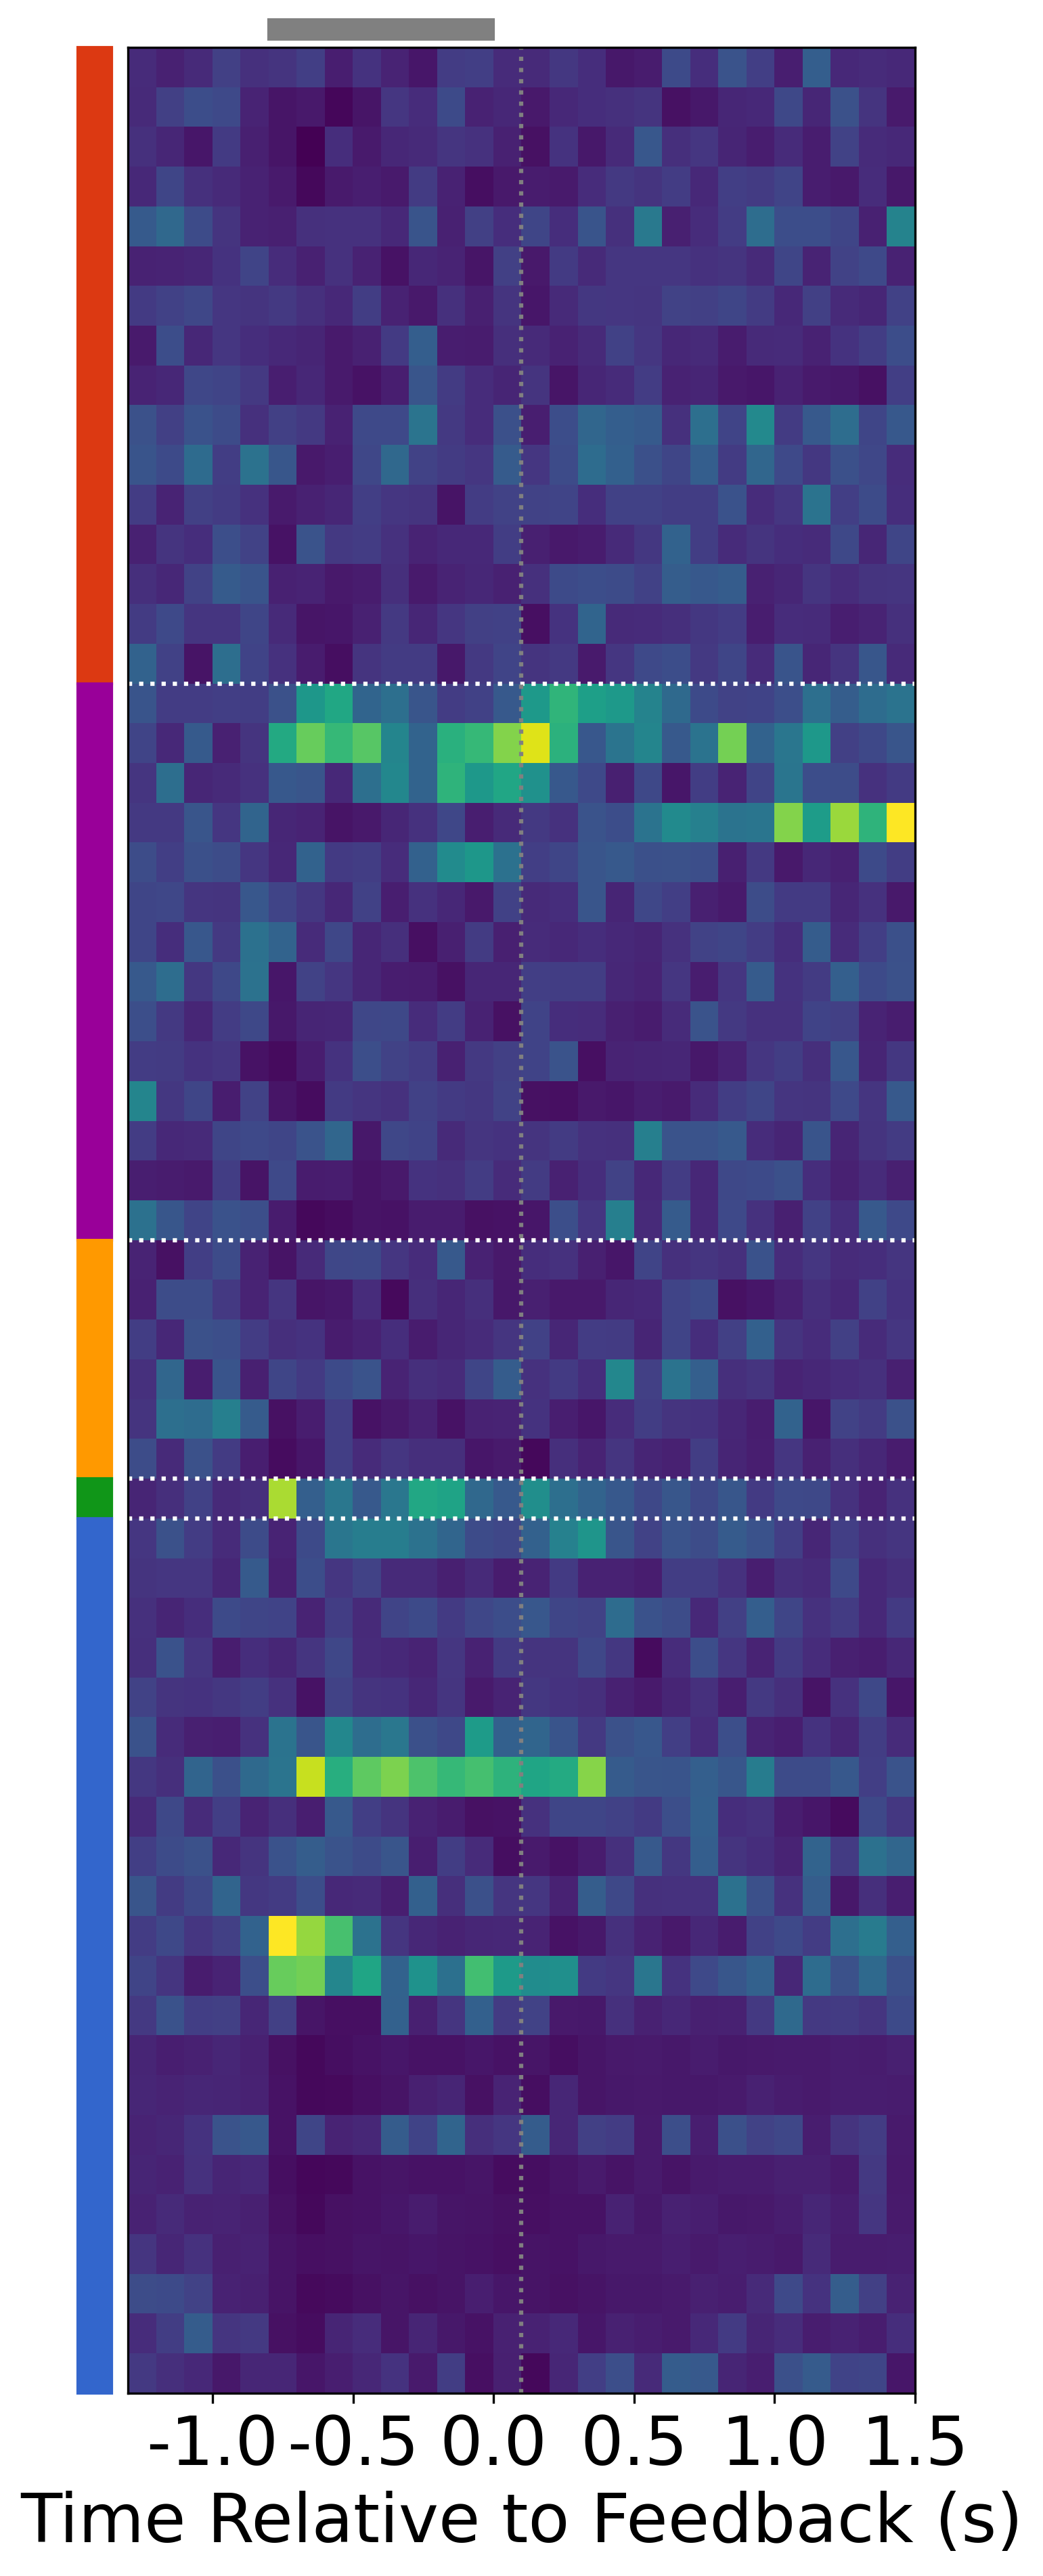

In [36]:
name_to_color = {
    "anterior hippocampus": '#3366CC', 
    "mpfc" : '#DC3912', 
    "parietal": '#FF9900', 
    "posterior hippocampus": '#109618', 
    "lpfc/fef": '#990099'
}
colormap = ["#DC3912", "#990099", "#FF9900", "#109618", "#3366CC"]

# models are num_time_points x num_models
pre_interval = 1300
post_interval = 1500
models = np.load(fs.open(f"l2l.pqz317.scratch/value_normed_model_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"), allow_pickle=True)
weights = classifier_utils.evaluate_model_weights_by_time_bins(models, 59, 12)

sums = np.sum(weights, axis=0)

normalized = weights / sums

# reorder by temp then ant
reordered = normalized[reordered_units, :]


matplotlib.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(figsize=(5, 15))
colors = ax.matshow(reordered, aspect='auto')
# tick_labels = np.array([-1.2, -0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9, 1.2])
tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
tick_pos = (tick_labels + 1.3) * 10 - 0.5
# fig.colorbar(colors)
# axis = np.arange(0, 28, 3)s
# labels = np.around((axis - 13) * 0.1, 1)
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)
ax.xaxis.tick_bottom()
ax.set_xlabel("Time Relative to Feedback (s)")
ax.get_yaxis().set_visible(False)
ax.set_ylabel([])
# y_axis = np.arange(0, 59, 5)
# ax.set_yticks(y_axis)
# ax.set_yticklabels(y_axis)

boundaries = np.insert(np.insert(lines, len(lines), reordered.shape[0] - 0.5), 0, -0.5)
print(lines)
print(len(boundaries))
for line in lines:
    ax.axhline(line, color='white', linestyle="dotted")

for i in range(len(boundaries)-1):
    rect = patches.Rectangle(
        (
            -1.3 - 1,
            (boundaries[i])#+boundaries[i+1]) / 2
        ),
        1.2,
        (boundaries[i+1]-boundaries[i]),
        edgecolor=colormap[i],
        facecolor=colormap[i],
        clip_on=False
    )
    ax.add_patch(rect)
gray_rect = patches.Rectangle(
    (4.5, -1.2), 8, 0.5,
    edgecolor="gray",
    facecolor="gray",
    clip_on=False,
)
ax.add_patch(gray_rect)
ax.axvline(13.48, color="gray", linestyle="dotted")
